In [48]:
import pickle

import numpy as np
import torch
import os
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [49]:
os.chdir('/Users/gouse/PycharmProjects/AR-Imperial-Thesis')
os.getcwd()

'/Users/gouse/PycharmProjects/AR-Imperial-Thesis'

In [50]:
feature_names_with_bins = ["thickness_small", "thickness_medium", "thickness_large", "thickness_xlarge",
                 "width_small", "width_medium", "width_large", "width_xlarge",
                 "length_small", "length_medium", "length_large", "length_xlarge"]
feature_names = ["thickness", "width", "length"]

class_names = ["6", "8", "9"]

# mapping from feature index to feature name
feature_index_to_name = {i: feature_name for i, feature_name in enumerate(feature_names)}
# mapping from feature name to feature index
feature_name_to_index = {feature_name: i for i, feature_name in enumerate(feature_names)}
# mapping from class index to class name
class_index_to_name = {i: class_name for i, class_name in enumerate(class_names)}
# mapping from class name to class index
class_name_to_index = {class_name: i for i, class_name in enumerate(class_names)}

In [51]:
# Download training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

train_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=False,
                              download=True,
                              transform=transform)

dict_of_lists = {6: [], 8: [], 9: []}
for i, (_, label) in enumerate(train_dataset):
    if label in dict_of_lists.keys():
        dict_of_lists[label].append(
            train_dataset.data[i].reshape(1, 28, 28))

for key in dict_of_lists.keys():
    dict_of_lists[key] = np.vstack(dict_of_lists[key]).reshape(-1, 1,
                                                               28, 28)
    if key == 8:
        X = torch.cat((torch.tensor(dict_of_lists[6]),
                       torch.tensor(dict_of_lists[8])))
    elif key > 8:
        X = torch.cat((X, torch.tensor(dict_of_lists[key])))

# import pickle files
with open('./datasets/MNIST/mine_preprocessed/area_dict.pkl', 'rb') as f:
    area = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict.pkl', 'rb') as f:
    length = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict.pkl', 'rb') as f:
    thickness = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict.pkl', 'rb') as f:
    slant = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict.pkl', 'rb') as f:
    width = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict.pkl', 'rb') as f:
    height = pickle.load(f)

# load the targets test
with open('./datasets/MNIST/mine_preprocessed/area_dict_test.pkl', 'rb') as f:
    area_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict_test.pkl', 'rb') as f:
    length_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict_test.pkl', 'rb') as f:
    thickness_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict_test.pkl', 'rb') as f:
    slant_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict_test.pkl', 'rb') as f:
    width_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict_test.pkl', 'rb') as f:
    height_test = pickle.load(f)

#### Return the minimum and the maximum value per bin, and select the 5 images which have a value closer to the minimum and 5 closer to the maximum per bin

In [52]:
targets = []
digits_size = 0
labels = []
# for i in range(4,10):
for i in [6, 8, 9]:
    # targets += list(
    #     zip(thickness[i], width[i], slant[i], height[i]))
    targets += list(
        zip(thickness[i], width[i], length[i]))
    # targets += list(
    # zip(thickness[i], area[i], length[i],
    #                     width[i], height[i], slant[i]))
    if i == 6:
        k = 0
    elif i == 8:
        k = 1
    else:
        k = 2
    # labels.append([(i-4) for j in range(len(targets) - digits_size)])
    labels.append([k for j in range(len(targets) - digits_size)])
    digits_size += len(width[i])

targets = np.array(targets)

def assign_bins(data, bin_edges):
    return np.digitize(data, bins=bin_edges, right=True)

# Convert bin numbers to one-hot encoded values
def one_hot_encode(bin_numbers, num_bins):
    return np.eye(num_bins)[bin_numbers - 1]

def process_data(targets, num_bins=4):
    bins_data_all = []
    min_max_values_all = []
    closest_images_all = []
    bin_counts = []

    for i in range(targets.shape[1]):
        # Combine the data
        combined_data = list(targets[:, i])

        # Sort the combined data
        combined_sorted = np.sort(combined_data)

        # Determine the number of data points per bin
        bin_size = len(combined_sorted) // num_bins

        # Calculate bin edges
        bin_edges = [combined_sorted[i * bin_size] for i in range(1, num_bins)] + [combined_sorted[-1]]
        bin_edges = [-np.inf] + bin_edges

        # Assign bins to the original data lists
        bins_data = assign_bins(targets[:, i], bin_edges)

        # Do one-hot encoding in the bins
        bins_data_encoded = one_hot_encode(bins_data, num_bins)

        # Get min and max values per bin
        min_max_values = []
        closest_images = []
        counts = []

        for bin_num in range(1, num_bins + 1):
            bin_indices = np.where(bins_data == bin_num)[0]
            bin_values = targets[bin_indices, i]
            counts.append(len(bin_indices))

            if len(bin_values) > 0:
                min_val = np.min(bin_values)
                max_val = np.max(bin_values)
                min_max_values.append((min_val, max_val))

                # Select 5 images closest to the minimum and 5 closest to the maximum
                closest_min_indices = bin_indices[np.argsort(np.abs(bin_values - min_val))[:5]]
                closest_max_indices = bin_indices[np.argsort(np.abs(bin_values - max_val))[:5]]
                closest_images.append((closest_min_indices, closest_max_indices))
            else:
                min_max_values.append((None, None))
                closest_images.append(([], []))

        bins_data_all.append(bins_data_encoded)
        min_max_values_all.append(min_max_values)
        closest_images_all.append(closest_images)
        bin_counts.append(counts)

    return bins_data_all, min_max_values_all, closest_images_all, bin_counts

# Example usage:
#targets = np.random.randn(100, 2)  # Example targets with 2 features and 100 samples
num_bins = 3
bins_data_all, min_max_values_all, closest_images_all, bin_counts = process_data(targets, num_bins=num_bins)

# Output the results
for feature_idx in range(targets.shape[1]):
    print(f"Feature {feature_idx}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        print(f"    Closest to Min: {closest_images_all[feature_idx][bin_idx][0]}")
        print(f"    Closest to Max: {closest_images_all[feature_idx][bin_idx][1]}")


Feature 0
  Bin 1: Min = 1.0608199852609512, Max = 2.2153042940554526
    Closest to Min: [ 5950  6513 16167  1617  8621]
    Closest to Max: [15802 11806   885  8316  3078]
  Bin 2: Min = 2.2153304911425726, Max = 2.728030336775153
    Closest to Min: [ 9055 12698 14372  2561  9787]
    Closest to Max: [15114 11973  7817  1434   148]
  Bin 3: Min = 2.7281567728343017, Max = 9.53389237525011
    Closest to Min: [14125 14116   768 16297 16603]
    Closest to Max: [ 6880 11069  6466  8310 10537]
Feature 1
  Bin 1: Min = 5.381124287425585, Max = 11.507589577022975
    Closest to Min: [12129 10069  1848  2104  1426]
    Closest to Max: [ 2586  7738 12833  8896 12055]
  Bin 2: Min = 11.508010420441556, Max = 13.766144365967923
    Closest to Min: [ 1495  3496 11329 15317  2021]
    Closest to Max: [ 1329  2549  9601 10916  5492]
  Bin 3: Min = 13.766264011908573, Max = 21.116715020198313
    Closest to Min: [14319 15045  7788 10278 13641]
    Closest to Max: [15279  4458  2270 13351 15146]


Feature 1, Bin 1: Min = 1.0608199852609512, Max = 2.2153042940554526


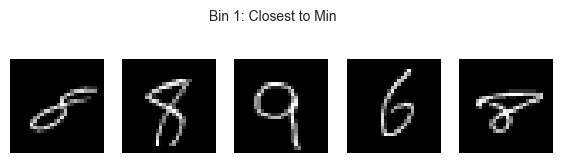

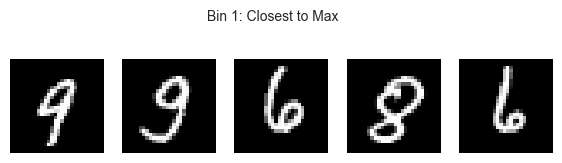

Feature 1, Bin 2: Min = 2.2153304911425726, Max = 2.728030336775153


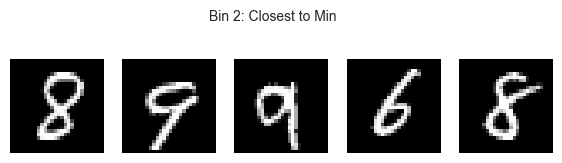

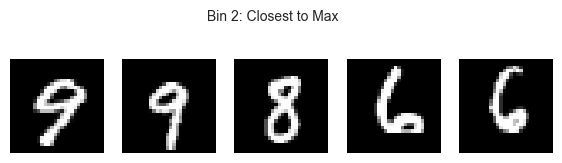

Feature 1, Bin 3: Min = 2.7281567728343017, Max = 9.53389237525011


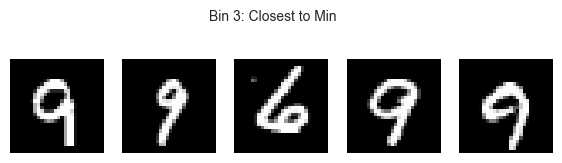

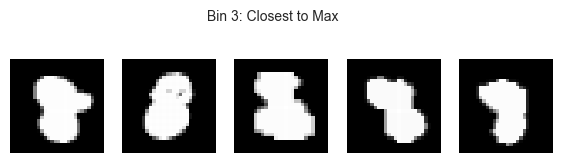

Feature 2, Bin 1: Min = 5.381124287425585, Max = 11.507589577022975


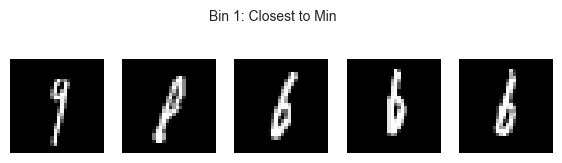

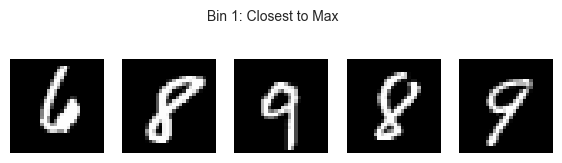

Feature 2, Bin 2: Min = 11.508010420441556, Max = 13.766144365967923


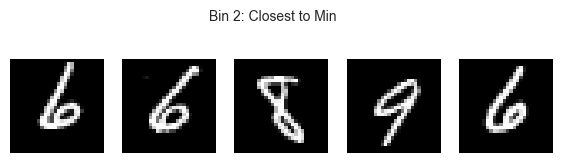

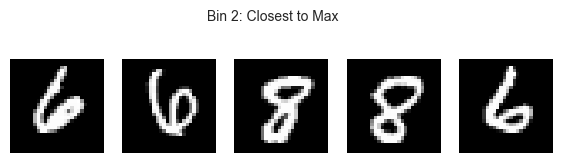

Feature 2, Bin 3: Min = 13.766264011908573, Max = 21.116715020198313


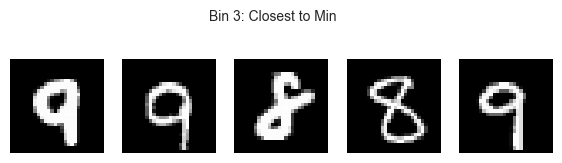

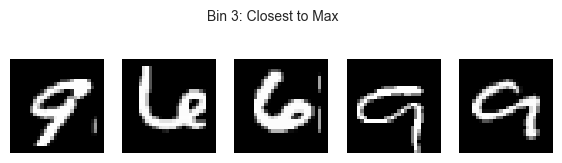

Feature 3, Bin 1: Min = 15.010407640085656, Max = 44.041630560342604


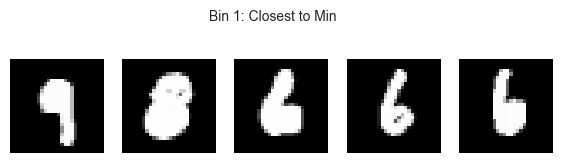

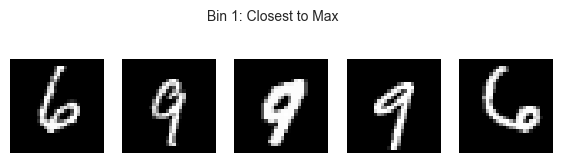

Feature 3, Bin 2: Min = 44.04163056034261, Max = 52.03427124746188


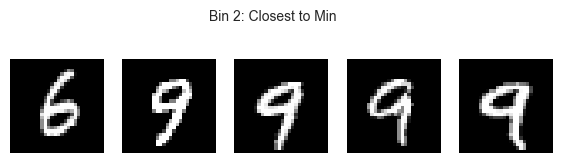

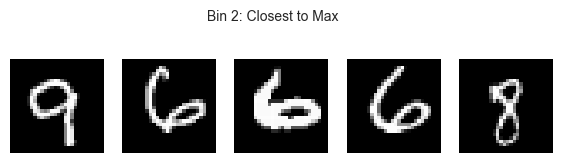

Feature 3, Bin 3: Min = 52.034271247461895, Max = 93.52133829043453


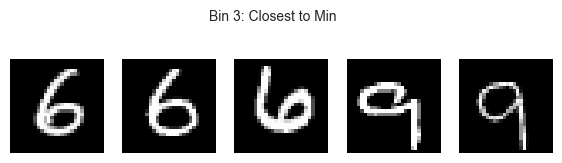

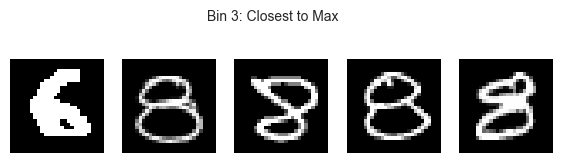

In [53]:
# Plotting the images
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(7, 2))
    fig.suptitle(title, fontsize=10)
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot closest images
for feature_idx in range(targets.shape[1]):
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"Feature {feature_idx + 1}, Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        
        closest_min_indices = closest_images_all[feature_idx][bin_idx][0]
        closest_max_indices = closest_images_all[feature_idx][bin_idx][1]
        
        if closest_min_indices.size > 0:
            plot_images(X[closest_min_indices], f"Bin {bin_idx + 1}: Closest to Min")
        if closest_max_indices.size > 0:
            plot_images(X[closest_max_indices], f"Bin {bin_idx + 1}: Closest to Max")

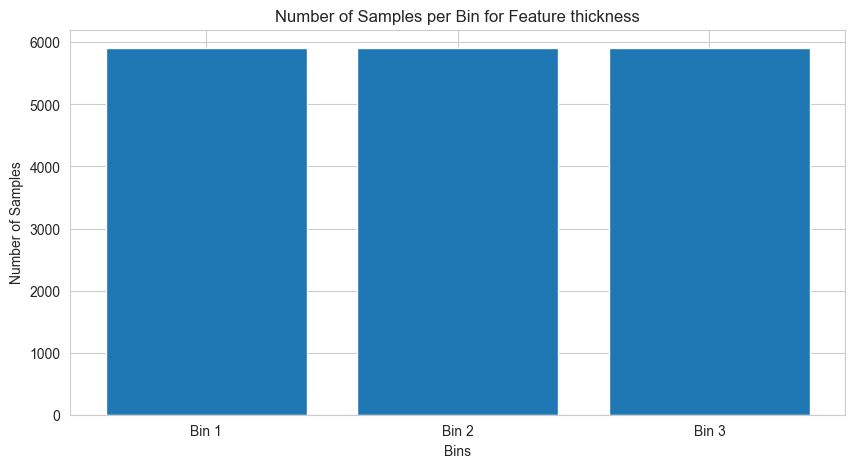

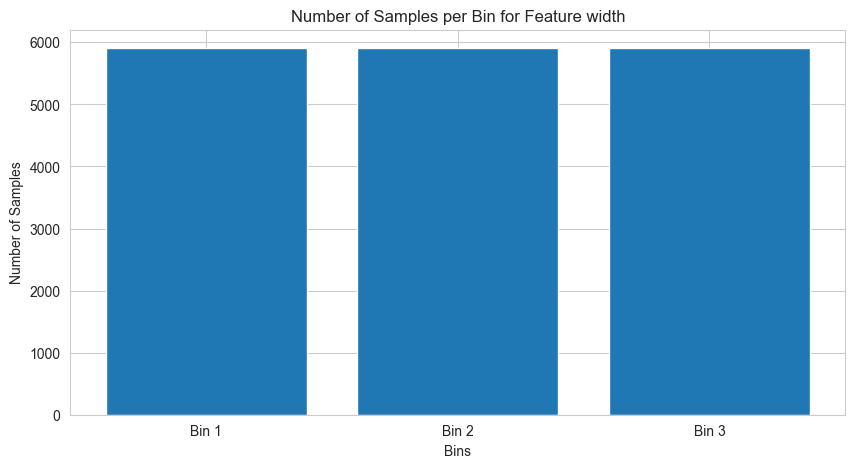

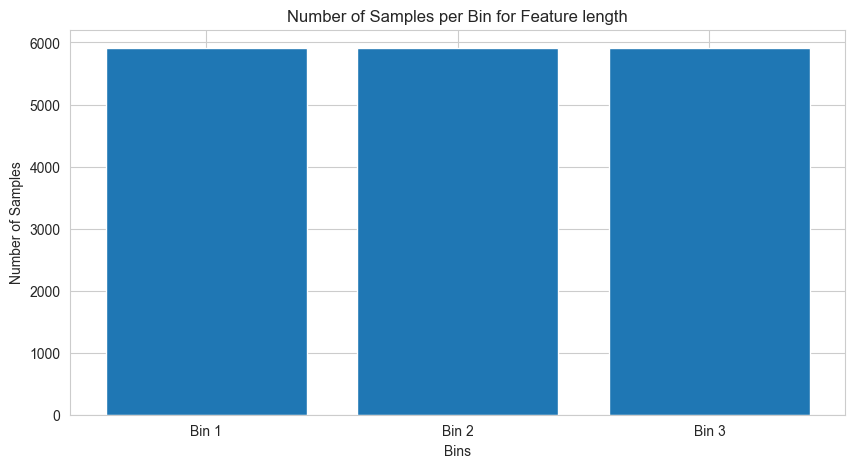

In [54]:
# Plotting the number of samples per bin per feature
for feature_idx in range(targets.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, num_bins + 1), bin_counts[feature_idx], tick_label=[f'Bin {i}' for i in range(1, num_bins + 1)])
    plt.xlabel('Bins')
    plt.ylabel('Number of Samples')
    plt.title(f'Number of Samples per Bin for Feature {feature_index_to_name[feature_idx]}')
    plt.show()

#### Change the process_data not to return bins of equal sizes but bins of equally distant features

In [55]:
def assign_bins(data, bin_edges):
    return np.digitize(data, bins=bin_edges, right=True)

# Convert bin numbers to one-hot encoded values
def one_hot_encode(bin_numbers, num_bins):
    return np.eye(num_bins)[bin_numbers - 1]

def process_data_not_equal_bins(targets, num_bins=4):
    bins_data_all = {}
    min_max_values_all = []
    closest_images_all = []
    bin_counts = []

    for i in range(targets.shape[1]):
        # Calculate bin edges for equally distant features
        min_val, max_val = np.min(targets[:, i]), np.max(targets[:, i])
        bin_edges = np.linspace(min_val, max_val, num_bins + 1)

        # Assign bins to the original data lists
        bins_data = assign_bins(targets[:, i], bin_edges)

        # Do one-hot encoding in the bins
        bins_data_encoded = one_hot_encode(bins_data, num_bins)

        # Get min and max values per bin
        min_max_values = []
        closest_images = []
        counts = []

        feature_bins_data = {}

        for bin_num in range(1, num_bins + 1):
            bin_indices = np.where(bins_data == bin_num)[0]
            bin_values = targets[bin_indices, i]
            counts.append(len(bin_indices))

            if len(bin_values) > 0:
                min_val = np.min(bin_values)
                max_val = np.max(bin_values)
                min_max_values.append((min_val, max_val))

                # Select 5 images closest to the minimum and 5 closest to the maximum
                closest_min_indices = bin_indices[np.argsort(np.abs(bin_values - min_val))[:5]]
                closest_max_indices = bin_indices[np.argsort(np.abs(bin_values - max_val))[:5]]
                closest_images.append((closest_min_indices, closest_max_indices))
            else:
                min_max_values.append((None, None))
                closest_images.append(([], []))

            feature_bins_data[bin_num] = list(bin_indices)

        bins_data_all[i] = feature_bins_data
        min_max_values_all.append(min_max_values)
        closest_images_all.append(closest_images)
        bin_counts.append(counts)

    return bins_data_all, min_max_values_all, closest_images_all, bin_counts

In [56]:
num_bins = 3
bins_data_all, min_max_values_all, closest_images_all, bin_counts = process_data_not_equal_bins(targets, num_bins=num_bins)

# Output the results
for feature_idx in range(targets.shape[1]):
    print(f"Feature {feature_idx}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        print(f"    Closest to Min: {closest_images_all[feature_idx][bin_idx][0]}")
        print(f"    Closest to Max: {closest_images_all[feature_idx][bin_idx][1]}")


Feature 0
  Bin 1: Min = 1.1339080196870484, Max = 3.8850987651058437
    Closest to Min: [ 6513 16167  1617  8621  2756]
    Closest to Max: [ 1334  1211 15459 15997 11501]
  Bin 2: Min = 3.885715921348113, Max = 6.6989662405918065
    Closest to Min: [ 4083  1957 11568 13088  8011]
    Closest to Max: [ 3921  9504 10930  4528  9097]
  Bin 3: Min = 6.766656901668796, Max = 9.53389237525011
    Closest to Min: [1037 6943 8698 1045   27]
    Closest to Max: [ 6880 11069  6466  8310 10537]
Feature 1
  Bin 1: Min = 5.571777934548008, Max = 10.625245352945136
    Closest to Min: [10069  1848  2104  1426 15014]
    Closest to Max: [16626  8474 16026  8420  2450]
  Bin 2: Min = 10.626329975874715, Max = 15.870615554945978
    Closest to Min: [10030 10453 12532  2980  8875]
    Closest to Max: [ 1712  6364 13505  3484  6866]
  Bin 3: Min = 15.871810629618833, Max = 21.116715020198313
    Closest to Min: [ 2014  1305 12265  8744  1708]
    Closest to Max: [15279  4458  2270 13351 15146]
Featur

Feature 1, Bin 1: Min = 1.1339080196870484, Max = 3.8850987651058437


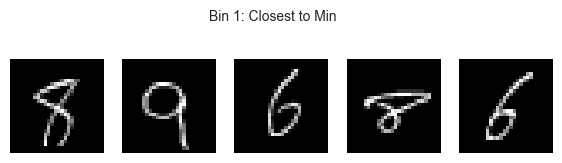

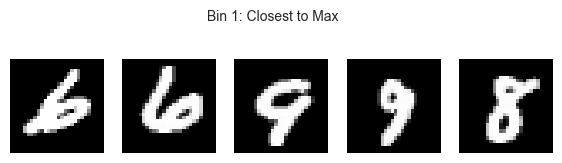

Feature 1, Bin 2: Min = 3.885715921348113, Max = 6.6989662405918065


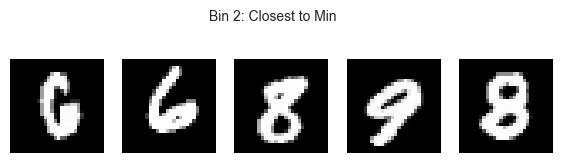

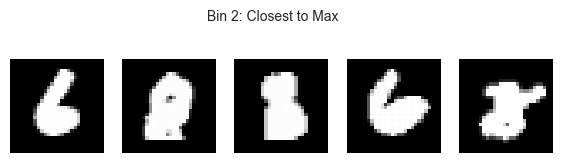

Feature 1, Bin 3: Min = 6.766656901668796, Max = 9.53389237525011


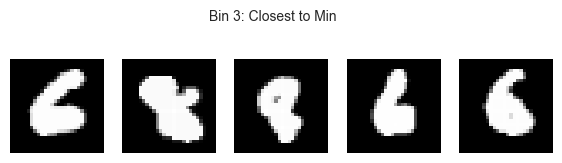

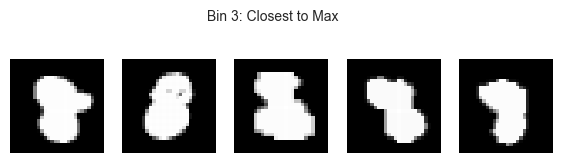

Feature 2, Bin 1: Min = 5.571777934548008, Max = 10.625245352945136


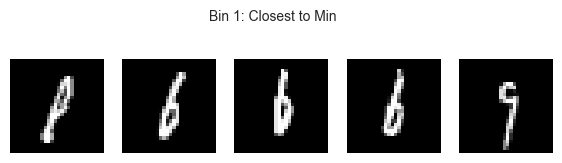

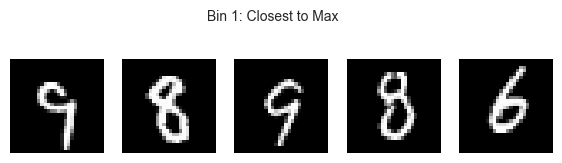

Feature 2, Bin 2: Min = 10.626329975874715, Max = 15.870615554945978


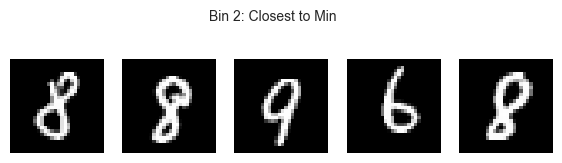

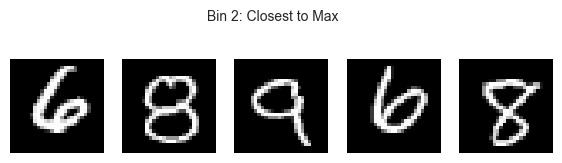

Feature 2, Bin 3: Min = 15.871810629618833, Max = 21.116715020198313


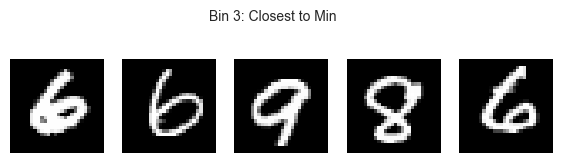

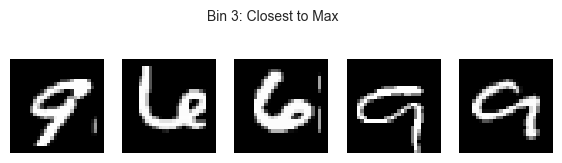

Feature 3, Bin 1: Min = 15.967514421272204, Max = 41.17766952966368


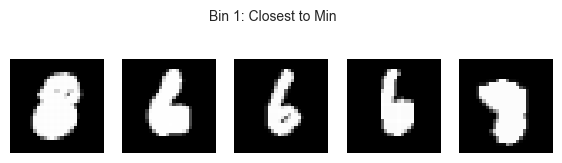

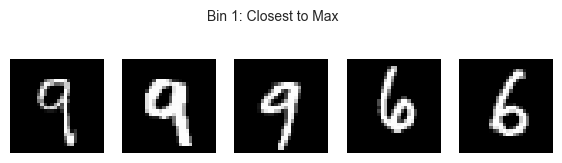

Feature 3, Bin 2: Min = 41.18071785686862, Max = 67.32285348059955


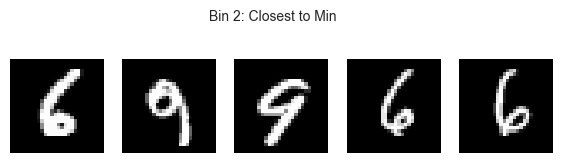

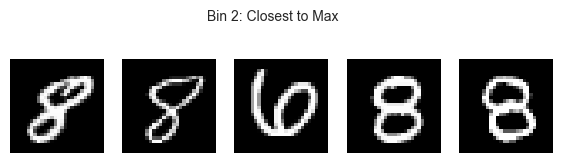

Feature 3, Bin 3: Min = 67.35533905932735, Max = 93.52133829043453


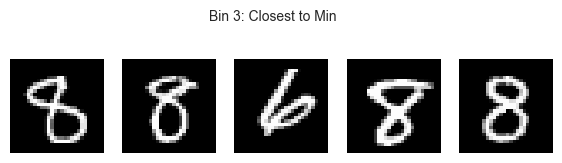

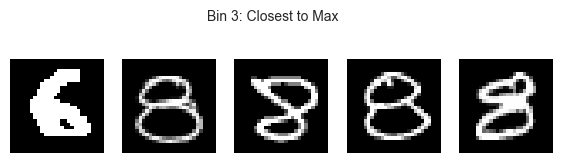

In [57]:
# Plotting the images
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(7, 2))
    fig.suptitle(title, fontsize=10)
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot closest images
for feature_idx in range(targets.shape[1]):
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"Feature {feature_idx + 1}, Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        
        closest_min_indices = closest_images_all[feature_idx][bin_idx][0]
        closest_max_indices = closest_images_all[feature_idx][bin_idx][1]
        
        if closest_min_indices.size > 0:
            plot_images(X[closest_min_indices], f"Bin {bin_idx + 1}: Closest to Min")
        if closest_max_indices.size > 0:
            plot_images(X[closest_max_indices], f"Bin {bin_idx + 1}: Closest to Max")

In [58]:
# Precompute the bin counts per class
def compute_class_bin_counts(targets, bins_data_all, num_bins, y):
    class_labels = np.unique(y)
    class_bin_counts = {cls: np.zeros((targets.shape[1], num_bins)) for cls in class_labels}
    
    for feature_idx in range(targets.shape[1]):
        for bin_num in range(1, num_bins + 1):
            bin_indices = bins_data_all[feature_idx][bin_num]
            for cls in class_labels:
                class_indices = np.where(y[bin_indices] == cls)[0]
                class_bin_counts[cls][feature_idx, bin_num - 1] = len(class_indices)
    
    return class_bin_counts

# Compute the class bin counts
class_bin_counts = compute_class_bin_counts(targets, bins_data_all, num_bins, np.hstack(labels))

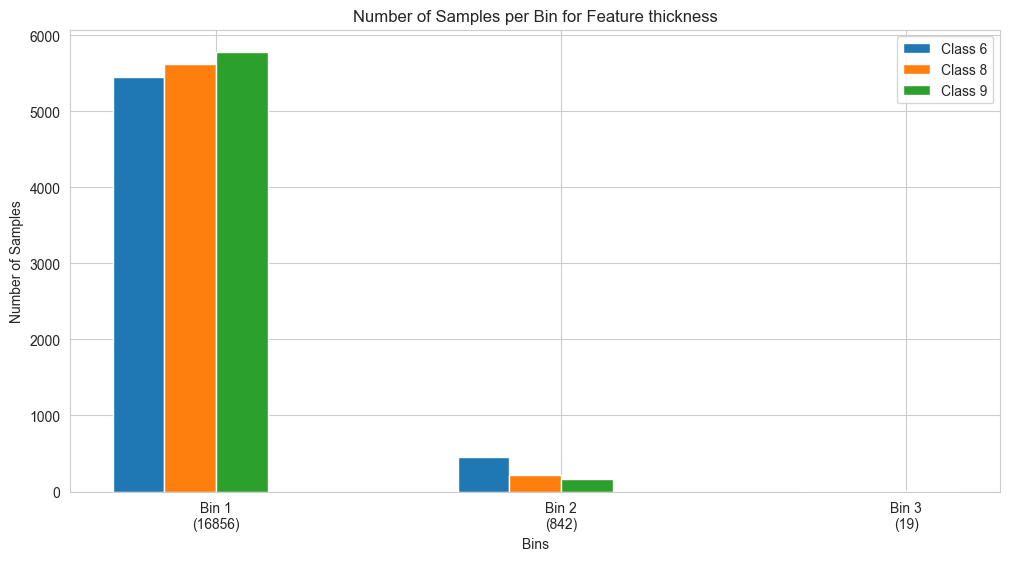

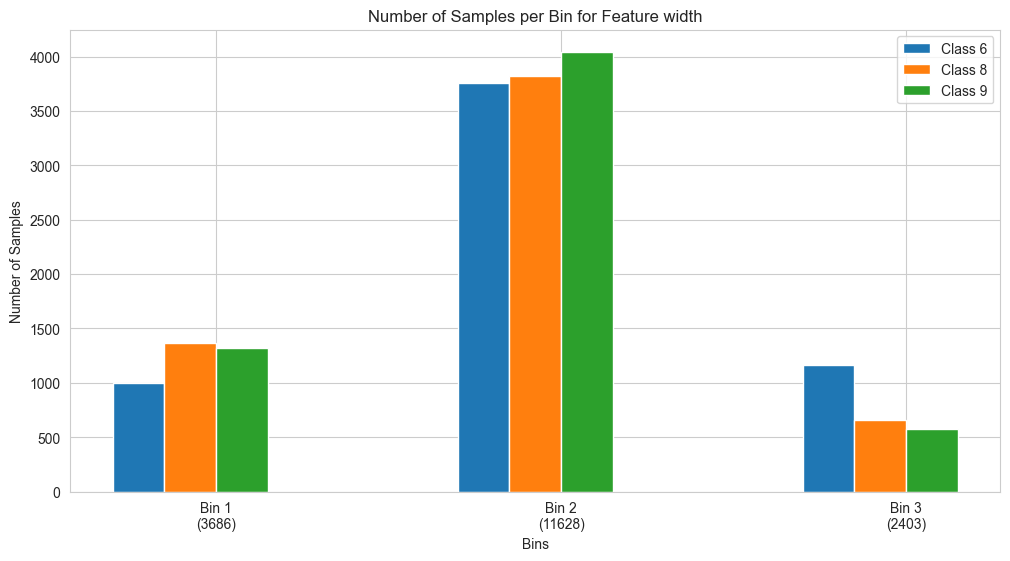

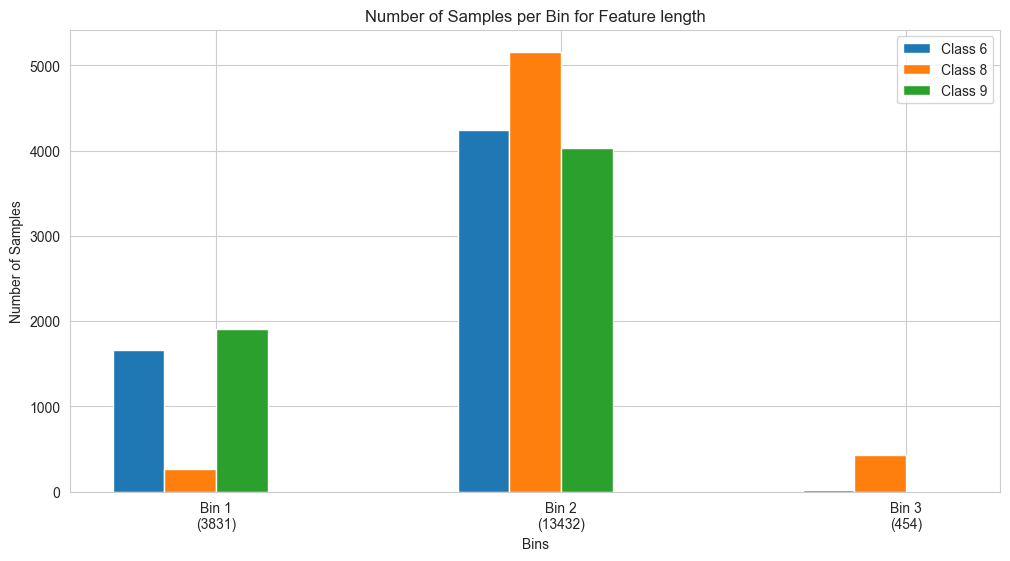

In [59]:
# Plotting the number of samples per bin per feature divided by class
for feature_idx in range(targets.shape[1]):
    bar_width = 0.15
    bin_labels = [f'Bin {i+1}\n({bin_counts[feature_idx][i]})' for i in range(num_bins)]
    r = np.arange(len(bin_labels))

    plt.figure(figsize=(12, 6))
    for cls in range(len(class_names)):
        plt.bar(r + (cls * bar_width), class_bin_counts[cls][feature_idx], width=bar_width, label=f'Class {class_index_to_name[cls]}')

    plt.xlabel('Bins')
    plt.ylabel('Number of Samples')
    plt.title(f'Number of Samples per Bin for Feature {feature_index_to_name[feature_idx]}')
    plt.xticks(r + bar_width * (len(class_names) / 2), bin_labels)
    plt.legend()
    plt.show()